# Redis as a high-performance machine learning database
## NLP : Identifying toxic comments

**Research question:** can Redis serve as a real-time database for both training and testing purposes when training a neural network in production? How could we get Redis to act as the back-end database serving training examples when training our model.

**IMPORTANT**: Make sure to have clone the repo, started a new Redis database instance locally before running this notebook. Refer to the `README.md` for further machine setup instructions.

In [178]:
import pandas as pd
import redis
from matplotlib import pyplot as plt
import timeit

## Part 2: Neural Network implementation

Redis is meant to be used in multiple ways and is basically a large-scale, distributed and high-performance key-value datastore. It also supports indexing and storage of JSON document, which we'll be using here to store both our **training** and **testing** datasets. 

According to our architecture, the `train:*` index prefix contains all the training example in JSON format and the `test:*` contains all the testing examples.

Let's make sure the database is filled up and ready to go by checking the dbsize(). 

**If the number printed below is zero, make sure you ran the `notebook-dataprep.ipynb` notebook and the `python ./fill_db.py` command. Prior to executing this notebook**.

In [179]:
# connect to local redis database
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

# checking to make sure every entries was inserted into database
r.dbsize()

223544

Now that we have the training and testing dataset into our Redis database, we'll define our neural network.

**Initializing the embeddings and tokenizer**:

We'll make sure of the `torchtext` python package which provides an out-of-the-box sentence tokenizer as well as the GloVe embedding. For this project, we decided to use the GloVe 840B embeddings of 300 dimensions for each words. Below we initialize both the tokenizer and the glove embeddings, running this cell might take some as it needs to fetch the embeddings remotely.

In [180]:
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(name='840B', dim=300)

We'll write our own torch `Dataset` and `DataLoader` definition to be used in conjunction with Pytorch. More specifically, this dataset and dataloader are going to query the Redis database to return both our testing and training data in real-time.

The dataset takes care of returning elements in our database one-by-one in an iterator fashion. 
The dataloader takes in the `collate_fn` as a parameter which `vectorize_batch` is passed in in order to encode the comment text into GloVe embeddings.

This way, Redis can act as the backend database for training the neural network using real time data.

In [ ]:
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.functional import to_map_style_dataset
import sys

MAX_COMMENT_LENGTH = 50
EMBED_LEN = 300
NORMAL_CLASS = "normal"
TARGET_CLASSES = [NORMAL_CLASS, "toxic", "obscene", "threat", "insult", "identity_hate"]

def get_target_class(obj, idx):
    labels = {attr: obj[attr] for attr in TARGET_CLASSES}
    return next((k for k, v in labels.items() if v == 1), None)

class RedisDataset(Dataset):
    def __init__(self, redis, redis_key_prefix):
        self.redis = redis
        self.length = len(self.redis.keys(redis_key_prefix + "*"))
        self.redis_key_prefix = redis_key_prefix

    def __len__(self):
        return self.length - 1
        
    def __getitem__(self, idx):
        key = self.redis_key_prefix + "%d" % idx
        obj = r.json().get(key)
        if obj is None:
            raise IndexError()
        label = get_target_class(obj, key)
        if label is None:
            label = NORMAL_CLASS
        return obj["comment_text"], TARGET_CLASSES.index(label)

In [181]:
train_dataset, test_dataset = RedisDataset(r, "train:"), RedisDataset(r, "test:")
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)
print("training db dataset length is", len(train_dataset))
print("testing db dataset length is", len(test_dataset))

training db dataset length is 159568
testing db dataset length is 63976


We not create the pytorch DataLoader for our custom Redis-backed dataset. The `vectorize_batch` function takes care of tokenzing and embedding the `comment_text` into the GloVe embeddings up to a `MAX_LENGTH` and pads it with empty string to fit the length of 0 in the case where the comment text is too short. 

In [182]:
def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (MAX_COMMENT_LENGTH-len(tokens)) if len(tokens) < MAX_COMMENT_LENGTH else tokens[:MAX_COMMENT_LENGTH] for tokens in X]
    X_tensor = torch.zeros(len(batch), MAX_COMMENT_LENGTH, EMBED_LEN)
    for i, tokens in enumerate(X):
        X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    return X_tensor.reshape(len(batch), -1), torch.tensor(Y)

train_loader, test_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch), DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)
for X, Y in train_loader:
    print(Y)
    break

tensor([0, 0, 0,  ..., 0, 0, 1])


Below we define our `ToxicCommentClassifier` which is a simple Pytorch neural network. It consists of 4 linear layers of 256, 128, 64 and 6 output units. We use the ReLU activation function after each layer.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F

class ToxicCommentClassifier(torch.nn.Module):
    def __init__(self):
        super(ToxicCommentClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(MAX_COMMENT_LENGTH*EMBED_LEN, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, len(TARGET_CLASSES))
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [183]:
def calculate_loss_and_accuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_processed, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_processed.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_processed = torch.cat(Y_processed)
        Y_preds = torch.cat(Y_preds)

        print("Validation loss", torch.tensor(losses).mean())
        print("Validation accuracy", accuracy_score(Y_processed.detach().numpy(), Y_preds.detach().numpy()))
        
losses_graph = []
def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=25):
    for i in range(1, epochs+1):
        print("Epoch #%d" % i)
        losses = []
        for X, Y in tqdm(train_loader): # for each batch
            Y_preds = model(X) # execute model

            loss = loss_fn(Y_preds, Y) # evaluate loss function
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward() # backward pass
            optimizer.step()

        losses_graph.append(torch.tensor(losses).mean())
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))

In [184]:
epochs = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
toxic_classifier = ToxicCommentClassifier()
optimizer = Adam(toxic_classifier.parameters(), lr=learning_rate)

train_model(toxic_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

Epoch #1


100%|██████████| 156/156 [00:46<00:00,  3.34it/s]


Train Loss : 0.268
Epoch #2


100%|██████████| 156/156 [00:46<00:00,  3.38it/s]


Train Loss : 0.149
Epoch #3


100%|██████████| 156/156 [00:43<00:00,  3.57it/s]


Train Loss : 0.121
Epoch #4


100%|██████████| 156/156 [00:43<00:00,  3.55it/s]


Train Loss : 0.097
Epoch #5


100%|██████████| 156/156 [00:44<00:00,  3.47it/s]


Train Loss : 0.082
Epoch #6


100%|██████████| 156/156 [00:43<00:00,  3.55it/s]


Train Loss : 0.068
Epoch #7


100%|██████████| 156/156 [00:44<00:00,  3.53it/s]


Train Loss : 0.056
Epoch #8


100%|██████████| 156/156 [00:43<00:00,  3.55it/s]


Train Loss : 0.043
Epoch #9


100%|██████████| 156/156 [00:44<00:00,  3.54it/s]


Train Loss : 0.031
Epoch #10


100%|██████████| 156/156 [00:45<00:00,  3.46it/s]

Train Loss : 0.031


In [185]:
def do_prediction(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = do_prediction(toxic_classifier, test_loader)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=TARGET_CLASSES))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8259503563836439

Classification Report : 
               precision    recall  f1-score   support

       normal       0.90      0.90      0.90     57733
        toxic       0.10      0.10      0.10      6090
      obscene       0.02      0.02      0.02        65
       threat       0.00      0.00      0.00         6
       insult       0.00      0.00      0.00        68
identity_hate       0.00      0.00      0.00        14

     accuracy                           0.83     63976
    macro avg       0.17      0.17      0.17     63976
 weighted avg       0.82      0.83      0.83     63976


Confusion Matrix : 
[[52247  5364    52     0    61     9]
 [ 5490   593     3     0     4     0]
 [   60     3     1     0     1     0]
 [    6     0     0     0     0     0]
 [   61     7     0     0     0     0]
 [   11     3     0     0     0     0]]


/home/jepoisso/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jepoisso/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jepoisso/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
def do_prediction(model, text):
    text_tokens = tokenizer(text)
    text_tokens = text_tokens[:MAX_COMMENT_LENGTH]
    X_tensor = torch.zeros(1, MAX_COMMENT_LENGTH, EMBED_LEN)
    if len(text_tokens) < MAX_COMMENT_LENGTH:
        text_tokens = text_tokens + ([""] * (MAX_COMMENT_LENGTH - len(text_tokens)))
    X_tensor[0] = global_vectors.get_vecs_by_tokens(text_tokens)
    preds = model(X_tensor.reshape(1, -1))
    pred_class = TARGET_CLASSES[(F.softmax(preds, dim=-1).argmax(dim=-1).detach().numpy())[0]]
    print("Sentence `%s` is most likely" % text, pred_class)
    return pred_class

do_prediction(toxic_classifier, "wow this project was great! such a great idea i have a dog named paul")
do_prediction(toxic_classifier, "paul is good bad dog but he always comments negative stuff")
do_prediction(toxic_classifier, "this is a lame project")
do_prediction(toxic_classifier, "i cant believe you spent that much time on this stinky project")


Sentence `wow this project was great! such a great idea i have a dog named paul` is most likely normal
Sentence `paul is good bad dog but he always comments negative stuff` is most likely normal
Sentence `this is a lame project` is most likely toxic
Sentence `i cant believe you spent that much time on this stinky project` is most likely toxic


'toxic'

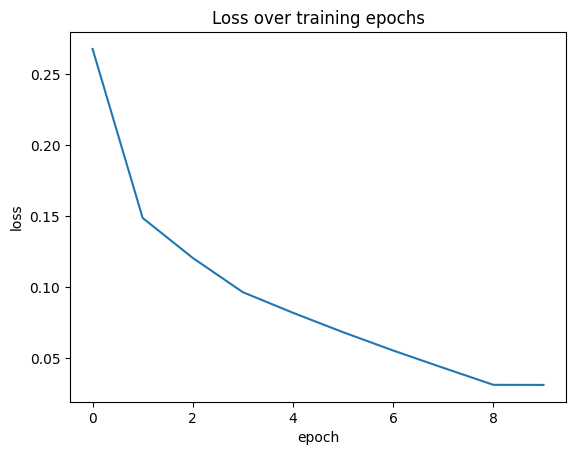

In [187]:
import matplotlib.pyplot as plt
losses = list(map(lambda t: t.detach().item(), losses_graph))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss over training epochs")
plt.show()

Now we can use the same `RedisDataset` to process unlabeled data in conjunction with Pytorch's DataLoader, similar to what we have done above for training and testing the model. Predictions are going to be stored at the same key for which it was returned.

Each entry in the `unlabeled:` index will be retrieved, passed through the model, and moved to the `label:*` index with its prediction.

In [188]:
from redis.commands.json.path import Path
test_example_0 = {
    'id': "jepoisso-0",
    'comment_text': "i love this project",
    'normal': 0,
    'toxic': 0,
    'severe_toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:0", Path.root_path(), test_example_0)

test_example_1 = {
    'id': "jepoisso-1",
    'comment_text': "you are dumb",
    'normal': 0,
    'toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:1", Path.root_path(), test_example_1)

from redis.commands.json.path import Path
test_example_2 = {
    'id': "jepoisso-2",
    'comment_text': "wow this is nice",
    'normal': 0,
    'toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:2", Path.root_path(), test_example_2)

from redis.commands.json.path import Path
test_example_3 = {
    'id': "jepoisso-3",
    'comment_text': "this is great",
    'normal': 0,
    'toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:3", Path.root_path(), test_example_3)

True

In [189]:
last_idx = len(r.keys("labeled:*"))
def process_unlabeled(model, loader):
    for X, Y in loader:
        preds = model(X)
        predicted_labels_idx = F.softmax(preds, dim=-1).argmax(dim=-1).detach().numpy().item()
        predicted_label = TARGET_CLASSES[predicted_labels_idx]
        print(predicted_label)

unlabeled_dataset = RedisDataset(r, "unlabeled:")
unlabeled_dataset = to_map_style_dataset(unlabeled_dataset)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, collate_fn=vectorize_batch)

process_unlabeled(toxic_classifier, unlabeled_loader)

normal
toxic
normal
normal
